### Sampling - Baseline : Latest MRR Filling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from util.env import get_device, set_device
from util.preprocess import build_loc_net, construct_data
from util.net_struct import get_feature_map, get_fc_graph_struc
from util.iostream import printsep

from datasets.TimeDataset_LF import TimeDataset

from models.GDN_GRU import GDN_GRU

from run.train import train
from run.test  import test
from run.evaluate import get_err_scores, get_best_performance_data, get_val_performance_data, get_full_err_scores

import sys
from datetime import datetime

import os
import argparse
from pathlib import Path

import json
import random

In [5]:
# check GPU situation
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
1
0
NVIDIA GeForce RTX 3090 Ti
11.8


In [6]:
# function to set random seed
def setup_seed(seed):
     random.seed(seed)
     np.random.seed(seed)
     if torch.cuda.is_available():
          torch.cuda.manual_seed(seed)
          torch.cuda.manual_seed_all(seed)
     torch.manual_seed(seed)
     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.benchmark = False

In [ ]:
class Main():
    def __init__(self, train_config, env_config, debug=False):

        self.train_config = train_config
        self.env_config = env_config
        self.datestr = None

        dataset = self.env_config['dataset']
        past_wafer = self.train_config['past_wafer']
        future_step = self.train_config['future_step']
        
        train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
        test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)
        self.train_orig = train_orig
        self.test_orig = test_orig

        # concat the past wafer referenced from training set
        test_extend = pd.concat((train_orig.iloc[-(316 * (past_wafer + future_step - 1)):,:], test_orig), ignore_index=True)

        train_past = self.transfer_to_input(train_orig, past_wafer)
        test_extend_past = self.transfer_to_input(test_extend, past_wafer)

        train, test = train_past, test_extend_past

        if 'attack' in train.columns:
            train = train.drop(columns=['attack'])

        feature_map = get_feature_map(dataset)
        fc_struc = get_fc_graph_struc(dataset)

        set_device(env_config['device'])
        self.device = get_device()

        fc_edge_index = build_loc_net(fc_struc, list(train.columns), feature_map=feature_map)
        fc_edge_index = torch.tensor(fc_edge_index, dtype = torch.long)

        self.feature_map = feature_map

        train_dataset_indata = construct_data(train, feature_map, labels=train.MRR.tolist())
        test_dataset_indata = construct_data(test, feature_map, labels=test.MRR.tolist())

        cfg = {
            'wafer_len': train_config['wafer_len'],
            'past_wafer': train_config['past_wafer'],
            'future_step': train_config['future_step'],
        }

        train_dataset = TimeDataset(train_dataset_indata, fc_edge_index, config=cfg, mode='train')
        test_dataset = TimeDataset(test_dataset_indata, fc_edge_index, config=cfg, mode='test')


        train_dataloader, val_dataloader = self.get_loaders(train_dataset, train_config['seed'], train_config['batch'], val_ratio = train_config['val_ratio'])

        self.train_dataset = train_dataset
        self.test_dataset = test_dataset


        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = DataLoader(test_dataset, batch_size=train_config['batch'],
                            shuffle=False)


        edge_index_sets = []
        edge_index_sets.append(fc_edge_index)

        self.model = GDN_GRU(edge_index_sets, len(feature_map), 
                dim=train_config['dim'], 
                input_dim=train_config['wafer_len'],
                topk=train_config['topk'],
                past_wafer=train_config['past_wafer'],
                gru_inter_dim=train_config['gru_inter_dim'],
                gru_layer_num=train_config['gru_layer_num']
            ).to(self.device)

    def run(self):

        if len(self.env_config['load_model_path']) > 0:
            model_save_path = self.env_config['load_model_path']
        else:
            model_save_path = self.get_save_path()[0]

            self.train_log = train(self.model, model_save_path, 
                config = self.train_config,
                train_dataloader=self.train_dataloader,
                val_dataloader=self.val_dataloader, 
                feature_map=self.feature_map,
                test_dataloader=self.test_dataloader,
                test_dataset=self.test_dataset,
                train_dataset=self.train_dataset,
                dataset_name=self.env_config['dataset']
            )
        
        # test            
        self.model.load_state_dict(torch.load(model_save_path))
        best_model = self.model.to(self.device)

        test_loss, test_result = test(best_model, self.test_dataloader)
        val_loss, val_result = test(best_model, self.val_dataloader)

        return test_loss, val_loss, test_result, val_result

    # split out the validation set and transfer into dataloaders
    def get_loaders(self, train_dataset, seed, batch, val_ratio=0.1):
        dataset_len = int(len(train_dataset))
        train_use_len = int(dataset_len * (1 - val_ratio))
        val_use_len = int(dataset_len * val_ratio)
        val_start_index = random.randrange(train_use_len)
        indices = torch.arange(dataset_len)

        train_sub_indices = torch.cat([indices[:val_start_index], indices[val_start_index+val_use_len:]])
        train_subset = Subset(train_dataset, train_sub_indices)

        val_sub_indices = indices[val_start_index:val_start_index+val_use_len]
        val_subset = Subset(train_dataset, val_sub_indices)

        train_dataloader = DataLoader(train_subset, batch_size=batch,
                                shuffle=False)

        val_dataloader = DataLoader(val_subset, batch_size=batch,
                                shuffle=False)

        return train_dataloader, val_dataloader

    def get_save_path(self, feature_name=''):

        dir_path = self.env_config['save_path']
        
        if self.datestr is None:
            now = datetime.now()
            self.datestr = now.strftime('%m_%d-%H_%M_%S')
        datestr = self.datestr          

        paths = [
            f'./save_path/{dir_path}/best_{datestr}.pt',
            f'./results/{dir_path}/{datestr}.csv',
        ]

        for path in paths:
            dirname = os.path.dirname(path)
            Path(dirname).mkdir(parents=True, exist_ok=True)

        return paths
    
    # reshape the input data [316, 19 x 4]
    def transfer_to_input(self, orig_data, past_wafer=4): 
        if not (1 <= past_wafer <= 5): # 5 can be change to max quantity of past wafers
            raise ValueError("past_wafer must be between 1 and 5")

        oldest_wafer = orig_data.iloc[:, :-1]
        wafer_list = [oldest_wafer]

        # place the SVIDs of past wafers into the column dimension
        for i in range(2, past_wafer + 1):
            wafer_n = pd.DataFrame(np.zeros_like(oldest_wafer), columns=[f'{col}_{i}' for col in oldest_wafer.columns])
            wafer_n.iloc[:-316*(i-1)] = oldest_wafer.iloc[316*(i-1):].values
            wafer_list.append(wafer_n)

        mrr = orig_data.iloc[:, -1]
        wafer_list.append(mrr)

        input_data = pd.concat(wafer_list, axis=1)

        return input_data

A456

In [ ]:
# training setting
batch=256
epoch=2000
wafer_len=316
past_wafer=4
dim=32
save_path_pattern='Last_Filling'
dataset='A456'
device='cuda'
seed=2
comment=''
decay=0
val_ratio=0.2
topk=4
report='best'
load_model_path=''
future_step=1
gru_inter_dim=64
gru_layer_num=3

# set random seed
setup_seed(seed)

train_config = {
    'batch': batch,
    'epoch': epoch,
    'wafer_len': wafer_len,
    'dim': dim,
    'comment': comment,
    'seed': seed,
    'decay': decay,
    'val_ratio': val_ratio,
    'topk': topk,
    'past_wafer' : past_wafer,
    'future_step' : future_step,
    'gru_inter_dim' : gru_inter_dim,
    'gru_layer_num' : gru_layer_num
}

env_config={
    'save_path': save_path_pattern,
    'dataset': dataset,
    'report': report,
    'device': device,
    'load_model_path': load_model_path
}

main = Main(train_config, env_config, debug=False)
test_loss, _, value_result, _ = main.run()

epoch (1 / 2000) (Train_loss:4105.27270508, ACU_loss:8210.54541016, Val_loss:3890.50488281)
epoch (2 / 2000) (Train_loss:4011.58972168, ACU_loss:8023.17944336, Val_loss:3813.35913086)
epoch (3 / 2000) (Train_loss:3918.23522949, ACU_loss:7836.47045898, Val_loss:3732.96582031)
epoch (4 / 2000) (Train_loss:3825.29589844, ACU_loss:7650.59179688, Val_loss:3648.73437500)
epoch (5 / 2000) (Train_loss:3734.46081543, ACU_loss:7468.92163086, Val_loss:3560.74023438)
epoch (6 / 2000) (Train_loss:3647.10498047, ACU_loss:7294.20996094, Val_loss:3469.95874023)
epoch (7 / 2000) (Train_loss:3563.02917480, ACU_loss:7126.05834961, Val_loss:3380.97412109)
epoch (8 / 2000) (Train_loss:3482.65283203, ACU_loss:6965.30566406, Val_loss:3297.42236328)
epoch (9 / 2000) (Train_loss:3405.69213867, ACU_loss:6811.38427734, Val_loss:3220.20849609)
epoch (10 / 2000) (Train_loss:3331.48266602, ACU_loss:6662.96533203, Val_loss:3147.60156250)
epoch (11 / 2000) (Train_loss:3259.38256836, ACU_loss:6518.76513672, Val_loss:3

MSE :  9.234


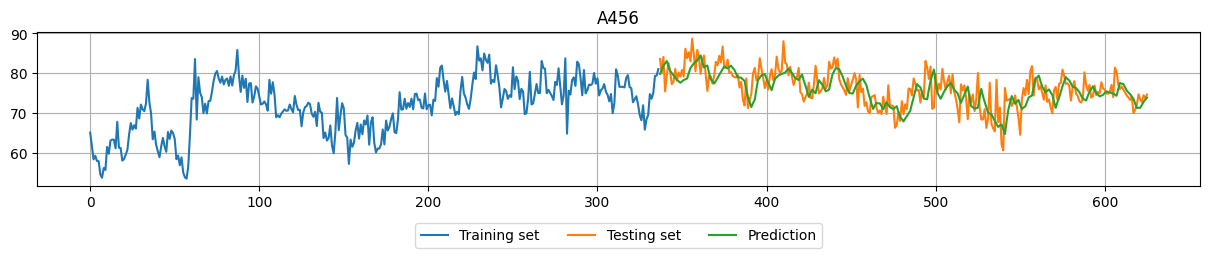

In [13]:
print('MSE : ', round(test_loss, 3))

# plot the result
y_train = [main.train_orig['MRR'][i] for i in range(0, len(main.train_orig), 316)]  
y_train = [y_train[i] for i in range(len(y_train)) if i % 2 == 0]
y_pred = np.array(value_result[0]).flatten()
y_truth = np.array(value_result[1])[:, 0].tolist()

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Train')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(['Training set', 'Testing set', 'Prediction'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))
plt.grid(True)
plt.show()

B456

In [18]:
# training setting
batch=256
epoch=2000
wafer_len=316
past_wafer=4
dim=16
save_path_pattern='Last_Filling'
dataset='B456'
device='cuda'
seed=2
comment=''
decay=0
val_ratio=0.2
topk=4
report='best'
load_model_path=''
future_step=1
gru_inter_dim=8
gru_layer_num=2

# set random seed
setup_seed(seed)

train_config = {
    'batch': batch,
    'epoch': epoch,
    'wafer_len': wafer_len,
    'dim': dim,
    'comment': comment,
    'seed': seed,
    'decay': decay,
    'val_ratio': val_ratio,
    'topk': topk,
    'past_wafer' : past_wafer,
    'future_step' : future_step,
    'gru_inter_dim' : gru_inter_dim,
    'gru_layer_num' : gru_layer_num
}

env_config={
    'save_path': save_path_pattern,
    'dataset': dataset,
    'report': report,
    'device': device,
    'load_model_path': load_model_path
}

main = Main(train_config, env_config, debug=False)
test_loss, _, value_result, _ = main.run()

epoch (1 / 2000) (Train_loss:1314.84490967, ACU_loss:2629.68981934, Val_loss:1223.55688477)
epoch (2 / 2000) (Train_loss:1267.67492676, ACU_loss:2535.34985352, Val_loss:1180.56140137)
epoch (3 / 2000) (Train_loss:1222.24847412, ACU_loss:2444.49694824, Val_loss:1138.27502441)
epoch (4 / 2000) (Train_loss:1177.99090576, ACU_loss:2355.98181152, Val_loss:1097.07702637)
epoch (5 / 2000) (Train_loss:1134.80700684, ACU_loss:2269.61401367, Val_loss:1056.69335938)
epoch (6 / 2000) (Train_loss:1092.34442139, ACU_loss:2184.68884277, Val_loss:1016.94134521)
epoch (7 / 2000) (Train_loss:1050.83660889, ACU_loss:2101.67321777, Val_loss:977.92474365)
epoch (8 / 2000) (Train_loss:1010.17199707, ACU_loss:2020.34399414, Val_loss:939.76306152)
epoch (9 / 2000) (Train_loss:970.58462524, ACU_loss:1941.16925049, Val_loss:902.60003662)
epoch (10 / 2000) (Train_loss:932.13943481, ACU_loss:1864.27886963, Val_loss:866.37951660)
epoch (11 / 2000) (Train_loss:894.76812744, ACU_loss:1789.53625488, Val_loss:831.2103

MSE :  16.591


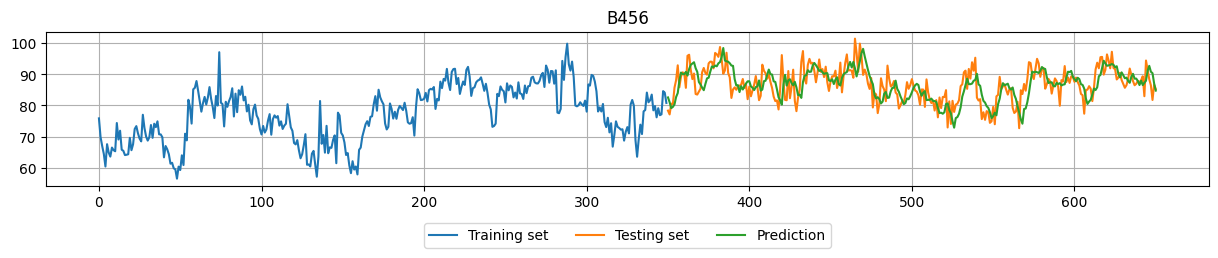

In [19]:
#print('MSE : ', test_loss)
print('MSE : ', round(test_loss, 3))

# plot the result
y_train = [main.train_orig['MRR'][i] for i in range(0, len(main.train_orig), 316)]  
y_train = [y_train[i] for i in range(len(y_train)) if i % 2 == 0]
y_pred = np.array(value_result[0]).flatten()
y_truth = np.array(value_result[1])[:, 0].tolist()

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Train')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(['Training set', 'Testing set', 'Prediction'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))
plt.grid(True)
plt.show()